# Фаза 2 • Неделя 8 • Среда
## Нейронные сети
### 🔥 PyTorch • CIFAR10

In [41]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.datasets import CIFAR10
from torchvision import transforms as T
from torch.nn import functional as F

import numpy as np
import torchutils as tu
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120
import mplcyberpunk
plt.style.use("cyberpunk")

torch.manual_seed(42)

Воспользуемся известным датасетом [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html), он содержит в себе изображения, принадлежащие 10 разным классам. 

![](https://3065708918-files.gitbook.io/~/files/v0/b/gitbook-legacy-files/o/assets%2F-LRrOFNeUGLZef_2NLZ0%2F-LeEJi2MCK6d2wToNmIy%2F-LeENgJqZAzBJi8PRELl%2Fcifar10.png?alt=media&token=bee1e40d-b4f6-4f46-a835-43d3f1223166)

Датасет уже есть в torchvision.datasets, потому загрузим его сразу в нужном формате. 

In [2]:
train_dataset = CIFAR10(
    root='data/',
    download=True, 
    train=True,
    transform=T.Compose(
        [
            T.Resize((32, 32)), # на всякий случай применяем приведение к нужному размеру (тут он по умолчанию 32)
            T.ToTensor(),
            T.Normalize(
                (.5, .5, .5), (.5, .5, .5) # нормализация
            )
        ]
    )
)

valid_dataset = CIFAR10(
    root='data/',
    download=True, 
    train=False,
    transform=T.Compose(
            [
                T.Resize((32, 32)),
                T.ToTensor(),
                T.Normalize(
                    (.5, .5, .5), (.5, .5, .5)
                )
            ]
        )
)

Files already downloaded and verified
Files already downloaded and verified


1. Создай два загрузчика (DataLoader): для обучающей и валидационной частей выборки. 

In [3]:
BATCH_SIZE = 128

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)

valid_loader = DataLoader(valid_dataset, shuffle=True, batch_size=BATCH_SIZE)

2. Задай класс модели в соответствии со схемой, приведенной ниже. 

![](aux/imgs/base_cnn.png)

In [52]:
class BaseCNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.flat = nn.Flatten()

        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.flat(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out

In [5]:
# cuda, если есть видеокарта, 
# cpu – если делаем локально и без видеокарты, 
# mps - если процессор M1/M2
device= 'cuda' if torch.cuda.is_available() else 'cpu'

3. Вызови функцию `get_model_summary` из бибилиотеки `torchutils`. 

In [ ]:
model = BaseCNN()
tu.get_model_summary(model.to(device), torch.randn(BATCH_SIZE, 3, 32, 32, device=device))

Layer                     Kernel            Output         Params        FLOPs
0_layer1.Conv2d_0       [3, 6, 5, 5]    [128, 6, 28, 28]      456   45,760,512
1_layer1.ReLU_1                    -    [128, 6, 28, 28]        0            0
2_layer1.MaxPool2d_2               -    [128, 6, 14, 14]        0            0
3_layer2.Conv2d_0      [6, 16, 5, 5]   [128, 16, 10, 10]    2,416   30,924,800
4_layer2.ReLU_1                    -   [128, 16, 10, 10]        0            0
5_layer2.MaxPool2d_2               -     [128, 16, 5, 5]        0            0
6_flat                             -          [128, 400]        0            0
7_fc1                     [400, 120]          [128, 120]   48,120   12,272,640
8_fc2                      [120, 84]           [128, 84]   10,164    2,569,728
9_fc3                       [84, 10]           [128, 10]      850      213,760
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
Total FLOPs: 91,741,440 / 91.74 MFLOPs
----------------------

/tmp/ipykernel_24396/2096663500.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out =  F.softmax(self.fc3(out))


In [62]:
model = BaseCNN()
model.to(device) # переносим на используемое устройство

BaseCNN(
  (layer1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

4. Задай функцию потерь и оптимизатор. 

In [63]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

5. Определи функцию `fit`, она должна возвращать данные, указанные в `docstring`. В функции должны присутствовать обучающие и валидационные шаги. 

In [55]:
def fit(
        model: torch.nn.Module, 
        n_epochs: int, 
        optimizer: torch.optim.Optimizer,
        train_loader: DataLoader,
        valid_loader: DataLoader
        ) -> tuple[list, ...]:
    """Function to fit model

    Returns:
        train_losses: list of train losses per epoch
        valid_losses: list of valid losses per epoch
        train_acc: list of train accuracy per epoch
        valid_acc: list of valid accuracy per epoch
    """

    train_loss = []
    valid_loss = []
    train_metric = []
    valid_metric = [] 

    for epoch in range(n_epochs):

        model.train()
        train_iter_loss = []
        train_iter_metric = []

        for images, labels in train_loader:

            images = images.to(device)
            labels = labels.to(device)

            y_pred = model(images)
            loss = criterion(y_pred, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_iter_loss.append(loss.item())
            train_iter_metric.append((y_pred.argmax(axis=1) == labels.to(device)).cpu().numpy().mean())


        model.eval()
        valid_iter_loss = []
        valid_iter_metric = []
        for images, labels in valid_loader:
            with torch.no_grad():
                y_pred = model(images.to(device))
            loss = criterion(y_pred, labels.to(device))
        
            valid_iter_loss.append(loss.item())
            valid_iter_metric.append((y_pred.cpu().argmax(dim=1) == labels.cpu()).numpy().mean())

        train_loss.append(np.mean(train_iter_loss))
        valid_loss.append(np.mean(valid_iter_loss))

        train_metric.append(np.mean(train_iter_metric))
        valid_metric.append(np.mean(valid_iter_metric))

        if epoch % 1 == 0:
            print(f'Epoch {epoch} finished: train_loss={train_loss[-1]:.3f}, train_metric={train_metric[-1]:.3f}')
            print(f'Epoch {epoch} finished: valid_loss={valid_loss[-1]:.3f}, valid_metric={valid_metric[-1]:.3f}')
            print(f'{"-"*35}')
            print()

    return train_loss, valid_loss, train_metric, valid_metric

In [64]:
train_loss, valid_loss, train_metric, valid_metric = fit(model, 20, optimizer, train_loader, valid_loader)

Epoch 0 finished: train_loss=1.644, train_metric=0.402
Epoch 0 finished: valid_loss=1.477, valid_metric=0.464
-----------------------------------

Epoch 1 finished: train_loss=1.385, train_metric=0.504
Epoch 1 finished: valid_loss=1.332, valid_metric=0.524
-----------------------------------

Epoch 2 finished: train_loss=1.272, train_metric=0.549
Epoch 2 finished: valid_loss=1.250, valid_metric=0.561
-----------------------------------

Epoch 3 finished: train_loss=1.208, train_metric=0.574
Epoch 3 finished: valid_loss=1.222, valid_metric=0.571
-----------------------------------

Epoch 4 finished: train_loss=1.176, train_metric=0.585
Epoch 4 finished: valid_loss=1.184, valid_metric=0.588
-----------------------------------

Epoch 5 finished: train_loss=1.145, train_metric=0.597
Epoch 5 finished: valid_loss=1.200, valid_metric=0.575
-----------------------------------

Epoch 6 finished: train_loss=1.122, train_metric=0.606
Epoch 6 finished: valid_loss=1.157, valid_metric=0.595
--------

6. Распечатай графики значений функции потерь на обучении и валидации, а также значения метрики на обучении и валидации. 

In [40]:
def plot_loss_metrics(tl: list, vl: list, tm: list, vm: list):
    _, ax = plt.subplots(1, 2, figsize=(14, 5))
    ax[0].plot(tl, label='Train loss')
    ax[0].plot(vl, label='Valid Loss')
    ax[0].legend()
    ax[0].set_title('Loss')
    ax[0].set_ylim((0, max(tl+vl)+.1))

    ax[1].plot(tm, label='Train accuracy')
    ax[1].plot(vm, label='Valid accuracy')
    ax[1].legend()
    ax[1].set_title('Accuracy')
    ax[1].set_ylim((0, max(tm+vm)+.1))

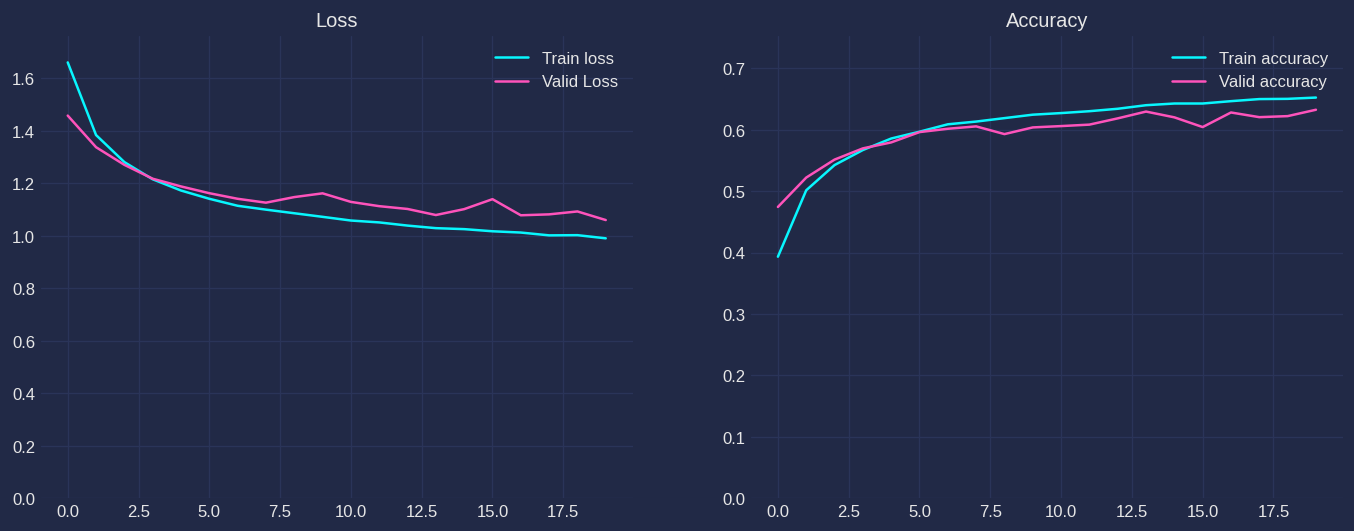

In [57]:
plot_loss_metrics(train_loss, valid_loss, train_metric, valid_metric)

7. Запиши результаты в переменные/словарь для последующего сравнения их с результатами более сложных моделей. 

In [65]:
result_baseline = {
    "train_loss" : train_loss, 
    "valid_loss" : valid_loss, 
    "train_metric" : train_metric, 
    "valid_metric" : valid_metric
}

8. Реализуй модель, изображенную на схеме ниже. 

![](aux/imgs/modified_cnn.png)

In [103]:
class ModifiedCNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.flat = nn.Flatten()

        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x: torch.Tensor):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.flat(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out
    
model = ModifiedCNN()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

9. Обучи модифицированную модель с помощью функции `fit()` и повтори шаги 6 и 7 для текущей модели. Не забудь передать в оптимизатор новые параметры (= создай его заново). 

In [104]:
train_loss, valid_loss, train_metric, valid_metric = fit(model, 20, optimizer, train_loader, valid_loader)

Epoch 0 finished: train_loss=1.854, train_metric=0.328
Epoch 0 finished: valid_loss=1.574, valid_metric=0.426
-----------------------------------

Epoch 1 finished: train_loss=1.515, train_metric=0.456
Epoch 1 finished: valid_loss=1.447, valid_metric=0.473
-----------------------------------

Epoch 2 finished: train_loss=1.408, train_metric=0.493
Epoch 2 finished: valid_loss=1.369, valid_metric=0.509
-----------------------------------

Epoch 3 finished: train_loss=1.345, train_metric=0.519
Epoch 3 finished: valid_loss=1.306, valid_metric=0.533
-----------------------------------

Epoch 4 finished: train_loss=1.290, train_metric=0.541
Epoch 4 finished: valid_loss=1.261, valid_metric=0.550
-----------------------------------

Epoch 5 finished: train_loss=1.240, train_metric=0.559
Epoch 5 finished: valid_loss=1.230, valid_metric=0.561
-----------------------------------

Epoch 6 finished: train_loss=1.197, train_metric=0.576
Epoch 6 finished: valid_loss=1.188, valid_metric=0.578
--------

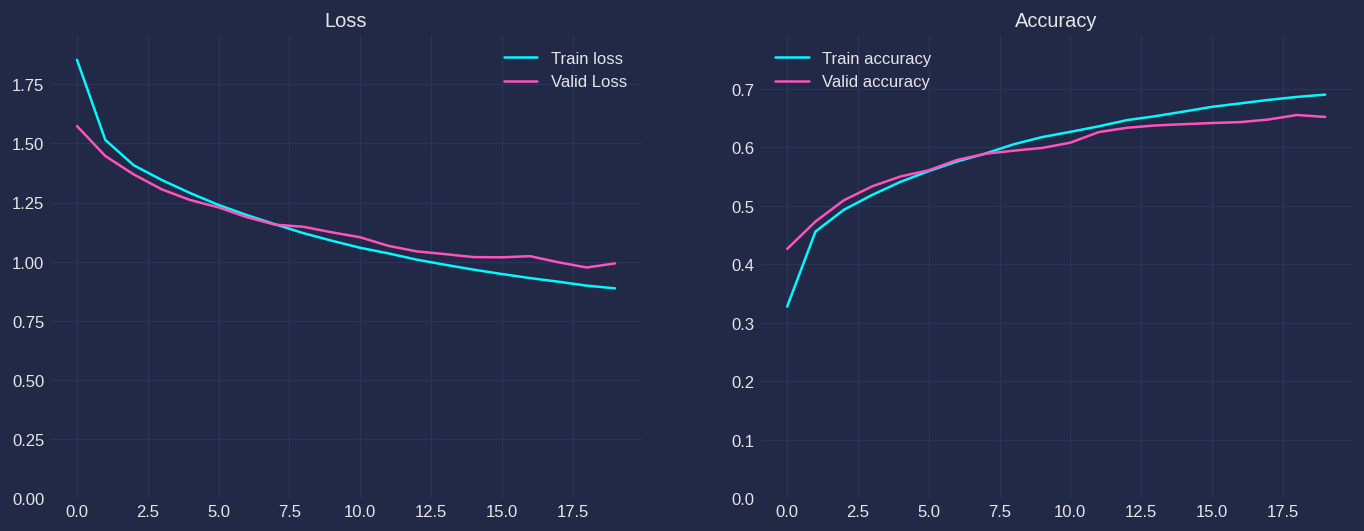

In [105]:
plot_loss_metrics(train_loss, valid_loss, train_metric, valid_metric)

In [75]:
result_modified_model = {
    "train_loss" : train_loss, 
    "valid_loss" : valid_loss, 
    "train_metric" : train_metric, 
    "valid_metric" : valid_metric
}

10. Реализуй архитектуру, приведенную ниже на схеме. Повтори для нее шаги 6 и 7. 

![](aux/imgs/big_cnn.png)

In [106]:
class BigCNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.flat = nn.Flatten()

        self.fc1 = nn.Linear(4096, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x: torch.Tensor):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.flat(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out
    
model = BigCNN()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
criterion = nn.CrossEntropyLoss()

In [107]:
train_loss, valid_loss, train_metric, valid_metric = fit(model, 20, optimizer, train_loader, valid_loader)

Epoch 0 finished: train_loss=1.700, train_metric=0.388
Epoch 0 finished: valid_loss=1.412, valid_metric=0.490
-----------------------------------

Epoch 1 finished: train_loss=1.312, train_metric=0.527
Epoch 1 finished: valid_loss=1.232, valid_metric=0.556
-----------------------------------

Epoch 2 finished: train_loss=1.163, train_metric=0.584
Epoch 2 finished: valid_loss=1.117, valid_metric=0.598
-----------------------------------

Epoch 3 finished: train_loss=1.056, train_metric=0.625
Epoch 3 finished: valid_loss=1.045, valid_metric=0.626
-----------------------------------

Epoch 4 finished: train_loss=0.972, train_metric=0.657
Epoch 4 finished: valid_loss=1.002, valid_metric=0.647
-----------------------------------

Epoch 5 finished: train_loss=0.908, train_metric=0.681
Epoch 5 finished: valid_loss=0.978, valid_metric=0.653
-----------------------------------

Epoch 6 finished: train_loss=0.855, train_metric=0.701
Epoch 6 finished: valid_loss=0.914, valid_metric=0.679
--------

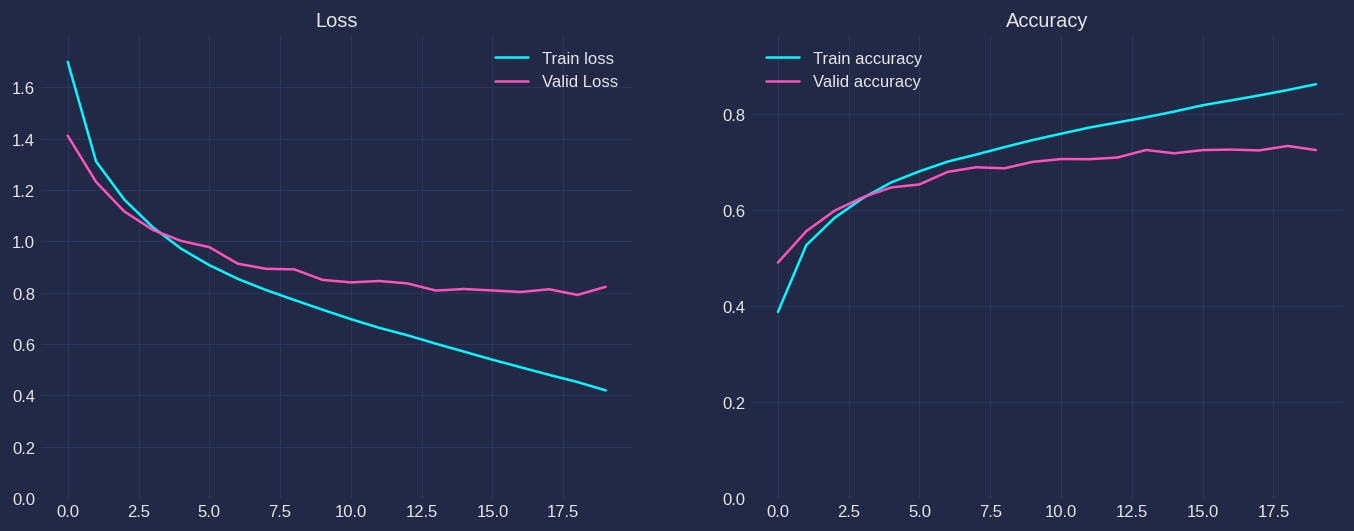

In [108]:
plot_loss_metrics(train_loss, valid_loss, train_metric, valid_metric)

In [109]:
result_big_model = {
    "train_loss" : train_loss, 
    "valid_loss" : valid_loss, 
    "train_metric" : train_metric, 
    "valid_metric" : valid_metric
}

11. Выясни по метриками, какая модель оказалась самой эффективной и сохрани в отдельный файл `best_model.py` ее класс, а в файл `best_model.pt` ее [веса](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference). 

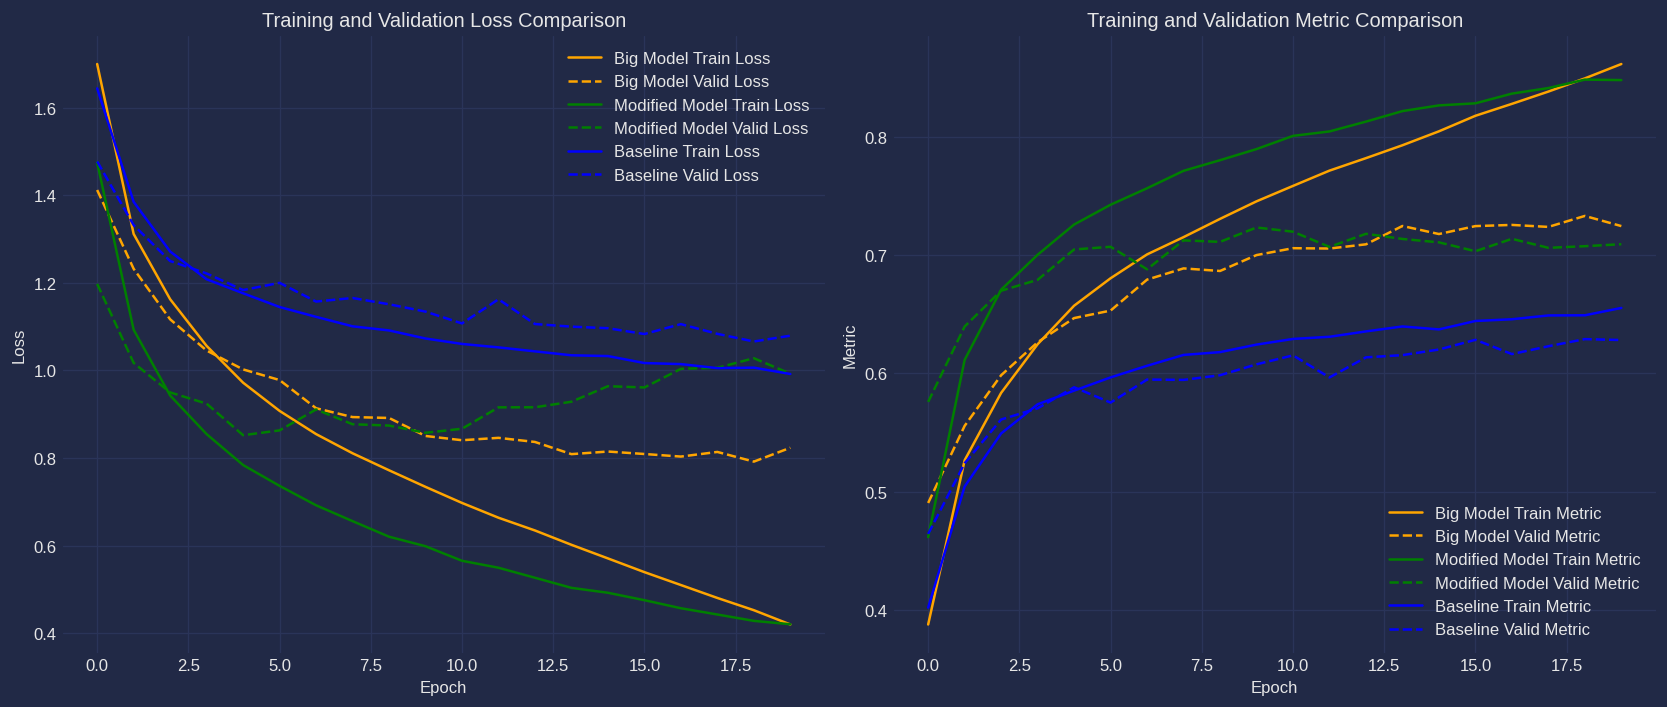

In [118]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(result_big_model["train_loss"], label='Big Model Train Loss', color='orange')
plt.plot(result_big_model["valid_loss"], label='Big Model Valid Loss', color='orange', linestyle='--')

plt.plot(result_modified_model["train_loss"], label='Modified Model Train Loss', color='green')
plt.plot(result_modified_model["valid_loss"], label='Modified Model Valid Loss', color='green', linestyle='--')

plt.plot(result_baseline["train_loss"], label='Baseline Train Loss', color='blue')
plt.plot(result_baseline["valid_loss"], label='Baseline Valid Loss', color='blue', linestyle='--')

plt.title('Training and Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)

plt.plot(result_big_model["train_metric"], label='Big Model Train Metric', color='orange')
plt.plot(result_big_model["valid_metric"], label='Big Model Valid Metric', color='orange', linestyle='--')

plt.plot(result_modified_model["train_metric"], label='Modified Model Train Metric', color='green')
plt.plot(result_modified_model["valid_metric"], label='Modified Model Valid Metric', color='green', linestyle='--')

plt.plot(result_baseline["train_metric"], label='Baseline Train Metric', color='blue')
plt.plot(result_baseline["valid_metric"], label='Baseline Valid Metric', color='blue', linestyle='--')

plt.title('Training and Validation Metric Comparison')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
#

12. Используй модель, показавшую наибольшее качество. Обучи ее дважды на двух наборах данных: 
* Датасет без аугментаций (тот, который был создан выше)
* Датасет с аугментациями (их надо добавить в Compose в аргумент датасета transform): 
  * [ColorJitter](https://pytorch.org/vision/stable/generated/torchvision.transforms.ColorJitter.html#torchvision.transforms.ColorJitter)
  * [RandomRotation](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomRotation.html#torchvision.transforms.RandomRotation)
  * [RandomHorizontalFlip](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomHorizontalFlip.html#torchvision.transforms.RandomHorizontalFlip)
Для этого создай два новых датасета (обучение/валидация) с названиями `trani_aug_dataset` и `valid_aug_dataset` и два загрузчика `train_aug_loader` и `valid_aug_loader`. 


Обучение должно происходить в течение 30 эпох (модель, котоая будет учиться на аугментированных данных возможно придется обучать и дольше – надо следить за значениями функции потерь). 

❓ Какой из двух вариантов показывает лучшее качество на валидационной части данных: где данными выступали обычные изображения без аугментаций или аугментированные данные? 

#### LeNet model

1. Реализуй модель LeNet в соответствии со схемой ниже, обучи её и сравни результаты с лучше собственной моделью (из реализованных выше). Число каналов во первом слое модели нужно изменить на 3, т.к. картинки цветные.  

<img src="https://www.philschmid.de/static/blog/getting-started-with-cnn-by-calculating-lenet-layer-manually/lenet-5.svg">

In [16]:
class LeNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        ...

    def forward(self, x: torch.Tensor):
        pass

In [17]:
# code

2. Обучи новый экземпляр модели LeNet, но на этот раз добавь в функцию потерь аргумент `label_smoothing=.2`. Сравни результат с предыдущим этапом. 

In [18]:
# code